<a href="https://colab.research.google.com/github/jarmokivekas/hotosm-activation-gis-resources/blob/master/report-automation/TM_project_status_report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Automated COVID-19 TM project status report

Maintainer: Jarmo Kivekäs (@jarmokivekas on HOTOSM slack).

This Jupyter notebook is intended to be executed in a google colab environment. To update the data displayed in the notebook, use the _Runtime_ > _Run all_ menu item in the top menu bar. 

Running the notebook in _playground mode_ lets you execute the notebook to update the data, without making any changes permanent changes. When you close the browser tab, any changes you've made or results of running the notebook are discarded. You don't have to always run the notebook. See the _TM Data aquisition_ section below to check to timestamp of when the data was updated.

Run the notebook in regular mode (as opposed to playground mode) and save using _File_ > _Save_ to update the notebook data outputs so that the next person sees the updated view.



In [ ]:
#@title Install Colab runtime dependencies
# When executing this notebook, if you get the error
# > ModuleNotFoundError: No module named 'tasking_manager_client'
# Uncomment and run this line to install the missing dependency:
!python3 -m pip install -q git+https://github.com/jarmokivekas/tasking-manager-client-python.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 972kB 5.4MB/s 
     |████████████████████████████████| 61kB 5.3MB/s 
     |████████████████████████████████| 10.9MB 32.8MB/s 
     |████████████████████████████████| 14.8MB 312kB/s 
     |████████████████████████████████| 102kB 11.0MB/s 


In [ ]:
#@title TM Data aquisition {display-mode: "form"}
import pandas as pd
import tasking_manager_client as tm
from datetime import datetime
from IPython.display import HTML, Markdown

# make sure pandas doesn't truncate the dataframe when rendered
pd.set_option('display.max_rows', 500)



# set the text search keyword
textSearch = 'covid'
projectStatuses = 'ARCHIVED,PUBLISHED,DRAFT'

# for notebooks used for reporting, it's nice to
# timestamp of the data, since it can get old quickly
now = datetime.utcnow()
print(f'data last updated: {now} UTC')
print(f'tasking manager:   {tm.DEFAULT_INSTANCE_API}')
print(f'search keyword:    {textSearch}')


# Collect the project data from the API
# concatenate paginated API results into one dataframe
result = pd.concat(tm.v2.project_search(textSearch=textSearch, projectStatuses=projectStatuses), ignore_index=True);
# search API pagination sometimes returns the same project more than once (due to pageintaion cacheing)
result = result.drop_duplicates(subset='projectId');

# The country column is has the country string wrapped in a 1-length list, convert it to a plain string
result['country'] = result['country'].apply(lambda val: val[0] if isinstance(val, list) else val)

# sort rows to be more reader friendly. Any number of columns can be given in
# the list for hierarchical sorting 
display_result = result.sort_values(by=['country','projectId' ])
# Many of the coulmns are unnecessary for an overview, we select only a few of them
display_result = display_result[['projectId', 'name', 'country', 'percentMapped','percentValidated', 'mapperLevel','status', 'priority']]


data last updated: 2020-10-01 10:22:41.881931 UTC
tasking manager:   tasking-manager-tm4-production-api.hotosm.org
search keyword:    covid


# Global statistics

This section contains basic statistics on all Tasking Manager projects found using a keyword search matching to "covid" (the `textSearch` api endpoint)


- Total number projects: 360
    - Drafts:    36
    - Published: 167 
    - Archived:  157
- Completed projects (100% mapped & validated): 220
- Average % mapped across all projects: 82.2 %
- Average % validated across all projects: 72.1 %


- Average completion rate: 1.16 projects/day

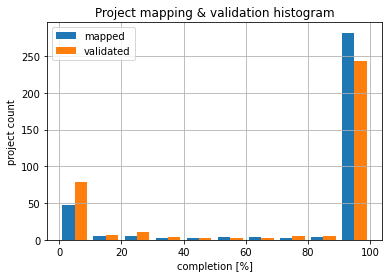

In [ ]:
#@title Globat stats summary {display-mode: "form"}
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime


def summarize_projects(df):
    """df: pandas dataframe of TM projects"""
    
    # number of projects completely mapped & validated
    completed = len(df[(df.percentMapped >= 99) & (df.percentValidated >= 99)])

    display(Markdown(
    f'''
- Total number projects: {len(df)}
    - Drafts:    {len(df[df.status=='DRAFT'])}
    - Published: {len(df[df.status=='PUBLISHED'])} 
    - Archived:  {len(df[df.status=='ARCHIVED'])}
- Completed projects (100% mapped & validated): {completed}
- Average % mapped across all projects: {df.percentMapped.mean():.1f} %
- Average % validated across all projects: {df.percentValidated.mean():.1f} %
'''))

summarize_projects(result)

# COVID-19 activation start
activation_date = datetime(2020,3,25)
activation_length = datetime.now() - activation_date
completed = len(result[(result.percentMapped >= 99) & (result.percentValidated >= 99)])

# average project completion rate during activation
completion_rate = completed / activation_length.days

display(Markdown(f'- Average completion rate: {completion_rate:.2f} projects/day'))


plt.figure()
plt.hist(
    [result['percentMapped'],result['percentValidated']],
    label=['mapped', 'validated'],
    bins=range(0,101,10))
plt.title('Project mapping & validation histogram')
plt.xlabel('completion [%]')
plt.ylabel('project count')
plt.legend();plt.grid()
plt.show()





## Pending Acrchival


The projects listed below have high (> 99 %) completion of both mapping and validation, and are in _Published_ status in Tasking Manager.
These are ready for a 2nd validation pass and eventually archiving

In [ ]:
#@title
def pending_archival(df):
    """list complete but still published TM projects"""
    pending_archival = df[
        (df.percentMapped >= 99) & \
        (df.percentValidated >= 99) & \
        (df.status == 'PUBLISHED')
    ]
    display(Markdown(str(list(pending_archival['projectId']))))
pending_archival(result)

[9358, 8816, 8825, 8826, 8827, 8874, 8875, 8876, 8877, 8878, 8879, 8884, 8885, 8886, 8906, 8907, 8908, 8909, 8910, 8911, 8912, 8914, 8915, 8917, 8918, 8920, 8935, 8936, 8937, 8938, 8939, 8940, 8980, 9012, 9013, 9015, 9027, 9034, 9045, 9048, 9053, 9075, 9173, 9176, 9196, 9214, 9215, 9216, 9218, 8188, 8416, 8545, 8551, 8552, 8553, 8555, 8556, 8596, 8597, 8598, 8599, 8600, 8704, 8766, 8771, 8795, 8812, 8815, 8817, 8823, 8841, 8843, 8880, 8925, 8926, 8963, 8964, 8986, 8988, 8989, 8992, 8997]

# Projects by Country



In [ ]:
#@title

def display_country(subset, country):

    # Add section heading
    display(Markdown(f'## {country}'))
    display(Markdown(f'---'))
    summarize_projects(subset)
    display(Markdown(f'---'))
    # Apply table styling and automatic colors
    styled = subset.style\
        .background_gradient(
            cmap=tm.style.hotosm_cmap(),
            subset=['percentMapped', 'percentValidated']
        )\
        .applymap(tm.style.format_priority, subset=['priority'])\
        .applymap(tm.style.format_status, subset=['status'])

    display(styled)

with pd.ExcelWriter('HOTOSM-covid-19-automatic.xlsx') as writer:

  for country in display_result.country.unique():
      subset = display_result[display_result.country == country]
      del subset['country']

      # export to excel sheet tab (long names truncated)
      subset.to_excel(
          writer,
          sheet_name=country[:30],
          index=False
      )

      # Display notebook output
      display_country(subset, country)

## Anguilla

---


- Total number projects: 1
    - Drafts:    0
    - Published: 1 
    - Archived:  0
- Completed projects (100% mapped & validated): 0
- Average % mapped across all projects: 100.0 %
- Average % validated across all projects: 53.0 %


---

,projectId,name,percentMapped,percentValidated,mapperLevel,status,priority
2,9178,COVID-19 - Anguilla Update,100,53,INTERMEDIATE,PUBLISHED,URGENT


## Barbados

---


- Total number projects: 11
    - Drafts:    11
    - Published: 0 
    - Archived:  0
- Completed projects (100% mapped & validated): 0
- Average % mapped across all projects: 0.0 %
- Average % validated across all projects: 0.0 %


---

,projectId,name,percentMapped,percentValidated,mapperLevel,status,priority
349,9473,"COVID-19 Saint Peter, Barbados",0,0,BEGINNER,DRAFT,LOW
350,9474,"COVID-19 Saint Thomas, Barbados",0,0,BEGINNER,DRAFT,LOW
351,9475,"COVID-19 Saint Andrew, Barbados",0,0,BEGINNER,DRAFT,LOW
352,9477,"COVID-19 Saint George, Barbados",0,0,BEGINNER,DRAFT,LOW
353,9478,"COVID-19 Saint Joseph, Barbados",0,0,BEGINNER,DRAFT,LOW
354,9479,"COVID-19 Saint Lucy, Barbados",0,0,BEGINNER,DRAFT,LOW
355,9480,"COVID-19 Saint Philip, Barbados",0,0,INTERMEDIATE,DRAFT,LOW
356,9481,"COVID-19 Christ Church, Barbados",0,0,INTERMEDIATE,DRAFT,LOW
357,9482,"COVID-19 Saint James, Barbados",0,0,INTERMEDIATE,DRAFT,LOW
358,9483,"COVID-19 Saint John, Barbados",0,0,INTERMEDIATE,DRAFT,LOW


## Belize

---


- Total number projects: 2
    - Drafts:    2
    - Published: 0 
    - Archived:  0
- Completed projects (100% mapped & validated): 0
- Average % mapped across all projects: 0.0 %
- Average % validated across all projects: 0.0 %


---

,projectId,name,percentMapped,percentValidated,mapperLevel,status,priority
347,9470,"COVID-19 Cayo District - Benque Viejo, Belize",0,0,BEGINNER,DRAFT,LOW
348,9472,"COVID-19 Corozal District - Inland, Belize",0,0,BEGINNER,DRAFT,LOW


## Botswana

---


- Total number projects: 59
    - Drafts:    0
    - Published: 3 
    - Archived:  56
- Completed projects (100% mapped & validated): 56
- Average % mapped across all projects: 98.6 %
- Average % validated across all projects: 95.8 %


---

,projectId,name,percentMapped,percentValidated,mapperLevel,status,priority
226,8512,"COVID-19 - Mogoditshane - Gaborone District, Botswana",100,100,BEGINNER,ARCHIVED,LOW
235,8571,"COVID-19 - Bokaa - Kgatleng District, Botswana",100,99,BEGINNER,ARCHIVED,LOW
45,8572,"COVID-19 - Gabane - Kweneng South District, Botswana",100,100,BEGINNER,ARCHIVED,MEDIUM
236,8573,"COVID-19 - Gaborone E - Gaborone District, Botswana",100,100,BEGINNER,ARCHIVED,LOW
237,8574,"COVID-19 - Gaborone N - Gaborone District, Botswana",99,99,BEGINNER,ARCHIVED,LOW
238,8575,"COVID-19 - Gaborone S- Gaborone District, Botswana",99,99,BEGINNER,ARCHIVED,LOW
239,8576,"COVID-19 - Kapong - Kgatleng District, Botswana",100,100,BEGINNER,ARCHIVED,LOW
240,8577,"COVID-19 - Matebele- Kgatleng District, Botswana",100,100,BEGINNER,ARCHIVED,LOW
241,8578,"COVID-19 - Metsimotlhabe- Kweneng South District, Botswana",100,100,BEGINNER,ARCHIVED,LOW
242,8579,"COVID-19 - Mmopane- Kweneng North District, Botswana",100,100,BEGINNER,ARCHIVED,LOW


## Brasil

---


- Total number projects: 2
    - Drafts:    0
    - Published: 2 
    - Archived:  0
- Completed projects (100% mapped & validated): 0
- Average % mapped across all projects: 99.5 %
- Average % validated across all projects: 7.5 %


---

,projectId,name,percentMapped,percentValidated,mapperLevel,status,priority
11,8788,"COVID-19 resilience strengthening in Marechal Rondon, Salvador, Bahia",100,7,BEGINNER,PUBLISHED,HIGH
12,8789,"COVID-19 resilience strengthening in Peninsula Itapagipe, Salvador, Bahia",99,8,BEGINNER,PUBLISHED,HIGH


## Brazil

---


- Total number projects: 1
    - Drafts:    0
    - Published: 1 
    - Archived:  0
- Completed projects (100% mapped & validated): 0
- Average % mapped across all projects: 0.0 %
- Average % validated across all projects: 0.0 %


---

,projectId,name,percentMapped,percentValidated,mapperLevel,status,priority
179,8317,#URBELatam #Covid-19 Mapping for Equitable Resilience in Morro do Preventório,0,0,BEGINNER,PUBLISHED,LOW


## Colombia

---


- Total number projects: 17
    - Drafts:    0
    - Published: 17 
    - Archived:  0
- Completed projects (100% mapped & validated): 1
- Average % mapped across all projects: 45.3 %
- Average % validated across all projects: 23.5 %


---

,projectId,name,percentMapped,percentValidated,mapperLevel,status,priority
136,8188,Mapatón COVID-19 Medellín - Comuna 1,100,100,BEGINNER,PUBLISHED,LOW
9,8189,Mapatón COVID-19 Medellín - Comuna 2,97,77,BEGINNER,PUBLISHED,HIGH
27,8190,Mapatón COVID-19 Medellín - Comuna 3,16,0,BEGINNER,PUBLISHED,MEDIUM
28,8191,Mapatón COVID-19 Medellín - Comuna 4,14,4,BEGINNER,PUBLISHED,MEDIUM
29,8192,Mapatón COVID-19 Medellín - Comuna 5,22,0,BEGINNER,PUBLISHED,MEDIUM
30,8193,Mapatón COVID-19 Medellín - Comuna 6,36,2,BEGINNER,PUBLISHED,MEDIUM
31,8194,Mapatón COVID-19 Medellín - Comuna 7,33,22,BEGINNER,PUBLISHED,MEDIUM
32,8195,Mapatón COVID-19 Medellín - Comuna 8,5,1,BEGINNER,PUBLISHED,MEDIUM
33,8196,Mapatón COVID-19 Medellín - Comuna 9,5,0,BEGINNER,PUBLISHED,MEDIUM
34,8197,Mapatón COVID-19 Medellín - Comuna 10,15,5,BEGINNER,PUBLISHED,MEDIUM


## Democratic Republic of the Congo

---


- Total number projects: 1
    - Drafts:    1
    - Published: 0 
    - Archived:  0
- Completed projects (100% mapped & validated): 0
- Average % mapped across all projects: 0.0 %
- Average % validated across all projects: 0.0 %


---

,projectId,name,percentMapped,percentValidated,mapperLevel,status,priority
43,8472,"COVID-19, Kinshasa, Gombe",0,0,INTERMEDIATE,DRAFT,MEDIUM


## Guyana

---


- Total number projects: 17
    - Drafts:    11
    - Published: 6 
    - Archived:  0
- Completed projects (100% mapped & validated): 0
- Average % mapped across all projects: 14.3 %
- Average % validated across all projects: 0.0 %


---

,projectId,name,percentMapped,percentValidated,mapperLevel,status,priority
105,9372,COVID-19 Lower Corentyne Rive,0,0,INTERMEDIATE,DRAFT,MEDIUM
106,9373,"COVID-19 Lower Corentyne Rive, Guyana",0,0,BEGINNER,DRAFT,MEDIUM
333,9374,"COVID-19 Lower Corentyne Rive, Guyana",64,0,BEGINNER,PUBLISHED,LOW
334,9405,"COVID-19 Waini - Kumaka, Guyana",99,0,BEGINNER,PUBLISHED,LOW
335,9406,"COVID-19 Moruka/Pomeroon - Pomeroon River, Guyana",0,0,BEGINNER,PUBLISHED,LOW
336,9407,"COVID-19 Somerset And Berks - Coast, Guyana",0,0,BEGINNER,PUBLISHED,LOW
337,9409,"COVID-19 Essequibo I./L.B.E.River - Islands, Guyana",0,0,BEGINNER,DRAFT,LOW
25,9410,"COVID-19 Bonasika/Boerasirie - Coast, Guyana",78,0,BEGINNER,PUBLISHED,HIGH
338,9411,"COVID-19 Lower West Demerara - Coast, Guyana",1,0,BEGINNER,DRAFT,LOW
339,9412,"COVID-19 Moblissa/La Reconnai - Coast, Guyana",0,0,BEGINNER,DRAFT,LOW


## Haiti

---


- Total number projects: 5
    - Drafts:    4
    - Published: 1 
    - Archived:  0
- Completed projects (100% mapped & validated): 0
- Average % mapped across all projects: 13.4 %
- Average % validated across all projects: 0.0 %


---

,projectId,name,percentMapped,percentValidated,mapperLevel,status,priority
19,9181,"Port-Salut Arrondissement Update, Sud, Haiti",67,0,INTERMEDIATE,PUBLISHED,HIGH
3,9182,"Côteaux Arrondissement, Sud, Haiti",0,0,INTERMEDIATE,DRAFT,URGENT
6,9192,"Chardonnières Arrondissement 1, Sud, Haiti",0,0,INTERMEDIATE,DRAFT,URGENT
7,9193,"Chardonnières Arrondissement 2, Sud, Haiti",0,0,INTERMEDIATE,DRAFT,URGENT
20,9315,"Sud Department, Haiti",0,0,BEGINNER,DRAFT,HIGH


## Jamaika

---


- Total number projects: 15
    - Drafts:    0
    - Published: 15 
    - Archived:  0
- Completed projects (100% mapped & validated): 6
- Average % mapped across all projects: 99.0 %
- Average % validated across all projects: 66.3 %


---

,projectId,name,percentMapped,percentValidated,mapperLevel,status,priority
311,8963,"COVID-19 - Clarendon, Jamaica",100,100,BEGINNER,PUBLISHED,LOW
312,8964,"COVID-19 - Hanover, Jamaica",100,100,BEGINNER,PUBLISHED,LOW
313,8986,"COVID-19 - Portland, Jamaica",100,100,BEGINNER,PUBLISHED,LOW
14,8987,"COVID-19 - Saint Ann, Jamaica",99,67,BEGINNER,PUBLISHED,HIGH
314,8988,"COVID-19 - Manchester, Jamaica",100,100,BEGINNER,PUBLISHED,LOW
315,8989,"COVID-19 - Saint Elizabeth, Jamaica",100,99,BEGINNER,PUBLISHED,LOW
1,8990,"COVID-19 - Saint James, Jamaica",99,77,BEGINNER,PUBLISHED,URGENT
316,8991,"COVID-19 - Saint Mary, Jamaica",99,29,BEGINNER,PUBLISHED,LOW
317,8992,"COVID-19 - Saint Thomas, Jamaica",99,99,BEGINNER,PUBLISHED,LOW
15,8994,"COVID-19 - Trelawny, Jamaica",99,77,BEGINNER,PUBLISHED,HIGH


## Kenya

---


- Total number projects: 3
    - Drafts:    0
    - Published: 3 
    - Archived:  0
- Completed projects (100% mapped & validated): 1
- Average % mapped across all projects: 66.3 %
- Average % validated across all projects: 53.7 %


---

,projectId,name,percentMapped,percentValidated,mapperLevel,status,priority
291,8823,COVID - 19 RAPID RESPONSE - DADAAB,100,100,ADVANCED,PUBLISHED,LOW
0,8863,COVID - 19 RAPID RESPONSE - KAKUMA,99,61,INTERMEDIATE,PUBLISHED,URGENT
111,9401,"Msambweni, Kwale County",0,0,INTERMEDIATE,PUBLISHED,MEDIUM


## Liberia

---


- Total number projects: 34
    - Drafts:    0
    - Published: 34 
    - Archived:  0
- Completed projects (100% mapped & validated): 30
- Average % mapped across all projects: 99.7 %
- Average % validated across all projects: 99.7 %


---

,projectId,name,percentMapped,percentValidated,mapperLevel,status,priority
47,8816,"COVID-19 Rapid Response Mapping: Montserrado County, Liberia",100,100,BEGINNER,PUBLISHED,MEDIUM
48,8825,"COVID-19 Rapid Response Mapping: Lofa County (Western), Liberia",100,100,BEGINNER,PUBLISHED,MEDIUM
49,8826,"COVID-19 Rapid Response Mapping: Lofa County (Central), Liberia",100,100,BEGINNER,PUBLISHED,MEDIUM
50,8827,"COVID-19 Rapid Response Mapping: Lofa County (Eastern), Liberia",100,100,BEGINNER,PUBLISHED,MEDIUM
51,8874,"COVID-19 Rapid Response Mapping: Grand Kru County, Liberia",100,100,BEGINNER,PUBLISHED,MEDIUM
52,8875,"COVID-19 Rapid Response Mapping: Maryland County, Liberia",100,100,BEGINNER,PUBLISHED,MEDIUM
53,8876,"COVID-19 Rapid Response Mapping: Sinoe County (Northern), Liberia",100,100,BEGINNER,PUBLISHED,MEDIUM
54,8877,"COVID-19 Rapid Response Mapping: Sinoe County (Eastern), Liberia",100,100,BEGINNER,PUBLISHED,MEDIUM
55,8878,"COVID-19 Rapid Response Mapping: Sinoe County (Western), Liberia",100,100,BEGINNER,PUBLISHED,MEDIUM
56,8879,"COVID-19 Rapid Response Mapping: River Gee County (Eastern), Liberia",100,100,BEGINNER,PUBLISHED,MEDIUM


## Malawi

---


- Total number projects: 1
    - Drafts:    0
    - Published: 1 
    - Archived:  0
- Completed projects (100% mapped & validated): 0
- Average % mapped across all projects: 80.0 %
- Average % validated across all projects: 24.0 %


---

,projectId,name,percentMapped,percentValidated,mapperLevel,status,priority
10,8697,Lilongwe Flood Risk Assessment,80,24,BEGINNER,PUBLISHED,HIGH


## Mali

---


- Total number projects: 15
    - Drafts:    1
    - Published: 7 
    - Archived:  7
- Completed projects (100% mapped & validated): 10
- Average % mapped across all projects: 76.9 %
- Average % validated across all projects: 73.3 %


---

,projectId,name,percentMapped,percentValidated,mapperLevel,status,priority
115,813,Mali - [Projets de Cartographie systématique - réseau routier principal vs référence open data],9,0,INTERMEDIATE,ARCHIVED,LOW
222,8469,"COVID-19 - Gao - Gao, Mali",100,100,INTERMEDIATE,ARCHIVED,LOW
223,8470,"COVID-19 - Kati - Koulikoro, Mali",100,100,INTERMEDIATE,ARCHIVED,LOW
224,8471,"COVID-19 - Koutiala Surroundings - Sikasso, Mali",100,100,BEGINNER,ARCHIVED,LOW
227,8545,"COVID-19 - Douentza Commune - Mopti, Mali",100,100,INTERMEDIATE,PUBLISHED,LOW
228,8546,"COVID-19 - Douentza City - Mopti, Mali",100,100,ADVANCED,ARCHIVED,LOW
277,8759,"COVID-19 - Yelimane Cercle - Kayes Region, Mali",100,100,BEGINNER,ARCHIVED,LOW
284,8771,"COVID-19 - Yelimane Cercle 2 - Kayes Region, Mali",100,100,BEGINNER,PUBLISHED,LOW
306,8924,Duplicate area of 8925 - Do Not Use,0,0,BEGINNER,ARCHIVED,LOW
307,8925,"COVID-19 - Yelimane Cercle 3 - Kayes Region, Mali",100,100,BEGINNER,PUBLISHED,LOW


## Marshall Islands

---


- Total number projects: 2
    - Drafts:    0
    - Published: 0 
    - Archived:  2
- Completed projects (100% mapped & validated): 2
- Average % mapped across all projects: 100.0 %
- Average % validated across all projects: 100.0 %


---

,projectId,name,percentMapped,percentValidated,mapperLevel,status,priority
95,9162,"Missing Maps: Marshall Islands, Majuro Atoll",100,100,INTERMEDIATE,ARCHIVED,MEDIUM
98,9185,"Missing Maps: Marshall Islands, Ailinglapalap Atoll",100,100,INTERMEDIATE,ARCHIVED,MEDIUM


## Mongolia

---


- Total number projects: 12
    - Drafts:    1
    - Published: 11 
    - Archived:  0
- Completed projects (100% mapped & validated): 0
- Average % mapped across all projects: 81.4 %
- Average % validated across all projects: 22.3 %


---

,projectId,name,percentMapped,percentValidated,mapperLevel,status,priority
117,7213,ZuunModMapathon2020,100,45,BEGINNER,PUBLISHED,LOW
120,7485,MurunMapathon2020,100,17,BEGINNER,PUBLISHED,LOW
180,8318,UndurKhaanMapathon2020,100,16,BEGINNER,PUBLISHED,LOW
181,8320,BaruunUrtMapathon2020,100,29,BEGINNER,PUBLISHED,LOW
213,8460,DarkhanMapathon2020,100,10,BEGINNER,PUBLISHED,LOW
214,8461,UlaangomMapathon2020,90,21,BEGINNER,PUBLISHED,LOW
215,8462,SainshandMapathon2020,100,42,BEGINNER,PUBLISHED,LOW
216,8463,UliastaiMapathon2020,100,76,BEGINNER,PUBLISHED,LOW
217,8464,SukhbaatarMapathon2020,98,12,BEGINNER,PUBLISHED,LOW
225,8473,TsetserlegMapathon2020,88,0,BEGINNER,PUBLISHED,LOW


## Nepal

---


- Total number projects: 1
    - Drafts:    0
    - Published: 1 
    - Archived:  0
- Completed projects (100% mapped & validated): 0
- Average % mapped across all projects: 68.0 %
- Average % validated across all projects: 6.0 %


---

,projectId,name,percentMapped,percentValidated,mapperLevel,status,priority
13,8942,Mapping the Unmapped in Province 2 of Nepal,68,6,INTERMEDIATE,PUBLISHED,HIGH


## Nigeria

---


- Total number projects: 1
    - Drafts:    0
    - Published: 1 
    - Archived:  0
- Completed projects (100% mapped & validated): 0
- Average % mapped across all projects: 31.0 %
- Average % validated across all projects: 0.0 %


---

,projectId,name,percentMapped,percentValidated,mapperLevel,status,priority
93,9068,"COVID-19: Maiduguri Metropolis, Northeast Nigeria",31,0,BEGINNER,PUBLISHED,MEDIUM


## Peru

---


- Total number projects: 106
    - Drafts:    0
    - Published: 16 
    - Archived:  90
- Completed projects (100% mapped & validated): 87
- Average % mapped across all projects: 99.7 %
- Average % validated across all projects: 98.5 %


---

,projectId,name,percentMapped,percentValidated,mapperLevel,status,priority
116,5909,"COVID-19, Quehue, Anna, Cusco Peru",100,100,BEGINNER,ARCHIVED,LOW
118,7372,"COVID-19 - Paucartambo 1, Cusco, Peru",100,100,BEGINNER,ARCHIVED,LOW
119,7379,"COVID-19 Yaurisque District, Cusco - Peru",100,100,BEGINNER,ARCHIVED,LOW
121,7719,"COVID-19 - Chinchero - Urubamba, Peru",100,100,BEGINNER,ARCHIVED,LOW
122,7720,"COVID-19 - Yucay, Cusco, Peru",100,100,BEGINNER,ARCHIVED,LOW
123,7721,"COVID-19 - Coya - Calca, Peru",100,100,BEGINNER,ARCHIVED,LOW
124,7768,"COVID-19 - Chamaca - Chumbivilcas, Peru",100,100,BEGINNER,ARCHIVED,LOW
125,7769,"COVID-19 - Saylla - Cusco , Peru",100,100,BEGINNER,ARCHIVED,LOW
126,7770,"COVID-19 San Jeronimo - Cusco , Peru",100,100,BEGINNER,ARCHIVED,LOW
127,7968,"COVID-19 - Andahuaylillas - Quispicanchi, Peru",100,100,BEGINNER,ARCHIVED,LOW


## Philippines

---


- Total number projects: 2
    - Drafts:    0
    - Published: 0 
    - Archived:  2
- Completed projects (100% mapped & validated): 2
- Average % mapped across all projects: 100.0 %
- Average % validated across all projects: 99.5 %


---

,projectId,name,percentMapped,percentValidated,mapperLevel,status,priority
182,8385,HOTPH-UP Covid-19 Response (QC #1),100,99,INTERMEDIATE,ARCHIVED,LOW
183,8386,HOTPH-UP Covid-19 Response (QC #2),100,100,INTERMEDIATE,ARCHIVED,LOW


## République Démocratique du Congo

---


- Total number projects: 1
    - Drafts:    1
    - Published: 0 
    - Archived:  0
- Completed projects (100% mapped & validated): 0
- Average % mapped across all projects: 0.0 %
- Average % validated across all projects: 0.0 %


---

,projectId,name,percentMapped,percentValidated,mapperLevel,status,priority
46,8609,"COVID-19, Ngaliema, Kinshasa (DRC)",0,0,INTERMEDIATE,DRAFT,MEDIUM


## South Africa

---


- Total number projects: 1
    - Drafts:    0
    - Published: 1 
    - Archived:  0
- Completed projects (100% mapped & validated): 0
- Average % mapped across all projects: 90.0 %
- Average % validated across all projects: 30.0 %


---

,projectId,name,percentMapped,percentValidated,mapperLevel,status,priority
135,8159,"Impendle, South Africa COVID-19",90,30,BEGINNER,PUBLISHED,LOW


## Sri Lanka

---


- Total number projects: 1
    - Drafts:    0
    - Published: 1 
    - Archived:  0
- Completed projects (100% mapped & validated): 0
- Average % mapped across all projects: 97.0 %
- Average % validated across all projects: 94.0 %


---

,projectId,name,percentMapped,percentValidated,mapperLevel,status,priority
41,8232,COVID-19_Sri Lanka_Akurana area,97,94,INTERMEDIATE,PUBLISHED,MEDIUM


## Suriname

---


- Total number projects: 7
    - Drafts:    1
    - Published: 6 
    - Archived:  0
- Completed projects (100% mapped & validated): 1
- Average % mapped across all projects: 64.3 %
- Average % validated across all projects: 39.3 %


---

,projectId,name,percentMapped,percentValidated,mapperLevel,status,priority
21,9334,"COVID-19 - Nickerie District, Suriname (2)",70,28,BEGINNER,PUBLISHED,HIGH
8,9341,"COVID-19 - Wanica District, Suriname",99,58,BEGINNER,PUBLISHED,URGENT
22,9356,"COVID-19 - Nieuw Nickerie, Nickerie District, Suriname",99,89,BEGINNER,PUBLISHED,HIGH
23,9357,"COVID-19 - Coronie District, Suriname",59,0,BEGINNER,PUBLISHED,HIGH
24,9358,"COVID-19 - Commewijne District, Suriname",100,100,BEGINNER,PUBLISHED,HIGH
104,9359,"COVID-19 - Saramacca District, Suriname",23,0,BEGINNER,PUBLISHED,MEDIUM
26,9489,"COVID-19 - Sipaliwini District, Suriname",0,0,BEGINNER,DRAFT,HIGH


## Uganda

---


- Total number projects: 31
    - Drafts:    3
    - Published: 28 
    - Archived:  0
- Completed projects (100% mapped & validated): 24
- Average % mapped across all projects: 82.9 %
- Average % validated across all projects: 80.6 %


---

,projectId,name,percentMapped,percentValidated,mapperLevel,status,priority
285,8795,Covid-19 Rapid Response - Mutukula Border Town,100,100,BEGINNER,PUBLISHED,LOW
289,8815,Covid-19 Rapid Response - Elegu Border Town,100,100,BEGINNER,PUBLISHED,LOW
290,8817,Covid-19 Rapid Response - Busia Border Town,100,100,BEGINNER,PUBLISHED,LOW
292,8841,Covid-19 Rapid Response - Malaba Border Town,100,100,BEGINNER,PUBLISHED,LOW
293,8843,Covid-19 Rapid Response - Entebbe International Airport,100,100,BEGINNER,PUBLISHED,LOW
57,8884,Covid-19 Rapid Response - Kalangala,100,100,BEGINNER,PUBLISHED,MEDIUM
58,8885,Covid-19 Rapid Response - Madi-Opei,100,100,BEGINNER,PUBLISHED,MEDIUM
59,8886,Covid-19 Rapid Response - Oraba,100,100,BEGINNER,PUBLISHED,MEDIUM
83,9012,Covid-19 Rapid Response - Katuna,100,100,BEGINNER,PUBLISHED,MEDIUM
84,9013,Covid-19 Rapid Response - Kikagati,100,100,BEGINNER,PUBLISHED,MEDIUM


## Yemen

---


- Total number projects: 1
    - Drafts:    0
    - Published: 1 
    - Archived:  0
- Completed projects (100% mapped & validated): 0
- Average % mapped across all projects: 98.0 %
- Average % validated across all projects: 2.0 %


---

,projectId,name,percentMapped,percentValidated,mapperLevel,status,priority
44,8547,"Population Displacement: Mapping buildings in #Marib, #Yemen",98,2,BEGINNER,PUBLISHED,MEDIUM


## Монгол Улс

---


- Total number projects: 9
    - Drafts:    0
    - Published: 9 
    - Archived:  0
- Completed projects (100% mapped & validated): 0
- Average % mapped across all projects: 80.0 %
- Average % validated across all projects: 15.2 %


---

,projectId,name,percentMapped,percentValidated,mapperLevel,status,priority
258,8607,AltaiMapathon2020,100,57,BEGINNER,PUBLISHED,LOW
259,8610,KhovdMapathon2020,100,32,BEGINNER,PUBLISHED,LOW
260,8611,#MandalGobiMapathon2020,41,0,BEGINNER,PUBLISHED,LOW
261,8612,BayankhongorMapathon2020,98,0,BEGINNER,PUBLISHED,LOW
262,8622,UlgiiMapathon2020,100,8,BEGINNER,PUBLISHED,LOW
263,8654,ArvaikheerMapathon2020,98,22,BEGINNER,PUBLISHED,LOW
264,8656,BulganMapathon2020,100,6,BEGINNER,PUBLISHED,LOW
326,9139,DalanzadgadMapathon2020,65,9,BEGINNER,PUBLISHED,LOW
327,9140,OrkhonMapathon2020,18,3,BEGINNER,PUBLISHED,LOW


## اليَمَن al-Yaman

---


- Total number projects: 1
    - Drafts:    0
    - Published: 1 
    - Archived:  0
- Completed projects (100% mapped & validated): 0
- Average % mapped across all projects: 23.0 %
- Average % validated across all projects: 0.0 %


---

,projectId,name,percentMapped,percentValidated,mapperLevel,status,priority
88,9031,"Population Displacement: Mapping buildings in #Marib, #Yemen (2)",23,0,BEGINNER,PUBLISHED,MEDIUM


# Access the data as a spreadsheet

Besides displaying the data inline in this notebook, it is also exported as an exccel file to the Colab workspace. See the file "HOTOSM-covid-19-automatic.xlsx" in the colab sidebard. You may need to click the "Referesh" icon in the file tree to see the exported spreadsheet.


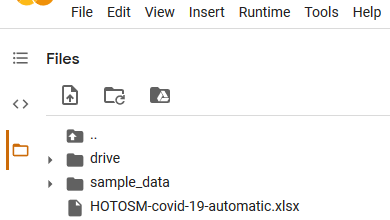

In [ ]:
import requests
import tasking_manager_client as tm 

url = tm.DEFAULT_INSTANCE_API
requests.get(f'https://{tm.DEFAULT_INSTANCE_API}/api/v2/projects/8763/contributions/queries/day').content

b'{"stats": [{"date": "2020-06-17", "mapped": 3, "validated": 0, "cumulative_mapped": 3, "cumulative_validated": 0, "total_tasks": 800}, {"date": "2020-06-28", "mapped": 1, "validated": 0, "cumulative_mapped": 4, "cumulative_validated": 0, "total_tasks": 800}, {"date": "2020-07-01", "mapped": 18, "validated": 0, "cumulative_mapped": 22, "cumulative_validated": 0, "total_tasks": 800}, {"date": "2020-07-02", "mapped": 85, "validated": 0, "cumulative_mapped": 107, "cumulative_validated": 0, "total_tasks": 800}, {"date": "2020-07-03", "mapped": 20, "validated": 0, "cumulative_mapped": 127, "cumulative_validated": 0, "total_tasks": 800}, {"date": "2020-07-06", "mapped": 36, "validated": 0, "cumulative_mapped": 163, "cumulative_validated": 0, "total_tasks": 800}, {"date": "2020-07-07", "mapped": 38, "validated": 0, "cumulative_mapped": 201, "cumulative_validated": 0, "total_tasks": 800}, {"date": "2020-07-08", "mapped": 20, "validated": 0, "cumulative_mapped": 221, "cumulative_validated": 0,